In [1]:
%pylab inline
plt.style.use('dark_background')
plt.rcParams['font.size'] = 14

Populating the interactive namespace from numpy and matplotlib


## Simulate the beam inside a cavity

Use the condition that in order for a mode to be resonant to a cavity, we must have the radii of curvature match the cavity walls at all points.

For a Gaussian Beam with width at focus of $w_0$ (assumed to be at $z = 0$ here), the radius of curvature is given by:

$$
R(z) = z\left[1+ \left(\frac{z_R}{z}\right)^2\right]
$$

where $z_R = \frac{\pi w_0^2}{\lambda}$ is the Rayleigh range. This is paramatrized by the complex $q$ parameter:

$$
q(z) = z + iz_R
$$

By inverting the above equation and doing a little algebra, we have:

$$
q^{-1}(z) = R^{-1}(z) - i\frac{\lambda}{\pi w(z)^2}
$$

Thus the $q$ parameter tells you all there is to know about the beam. 

$$ 
\begin{align}
z_0 &= \text{Re}\left[q(z)\right] \\
z_R &= \text{Im}\left[q(z)\right] \\
w_0 &= \sqrt{\frac{\lambda z_R}{\pi}}\\
R(z) &= \left(\text{Re}\left[q^{-1}(z)\right]\right)^{-1} \\
w(z) &= \sqrt{\frac{-\lambda/\pi}{\text{Im}\left[q^{-1}(z)\right]}}
\end{align}
$$

## Current cavity calculations

Our cavity has $R_0=50$mm. We will place the mirrors a distance $L$ apart. Since we have mirrors withthe same curvature, the Gaussian beam must have its waist equidistant between the two mirrors by symmetry. Let's call this point $z=0$. Let $d = L/2$ be the distance to the mirror. Then

$$
R(d) = d\left[1+\left(\frac{z_r}{d}\right)^2\right] = R_0
$$

or 

$$
z_R = \sqrt{dR_0-d^2}
$$

We see immediately that for a stable cavity we must have have $d < R_0$, giving a maximum cavity length of $L_\text{max} = 2R_0$, i.e. a concentric cavity. 

On the other hand, there is no stability limit on how close the cavity mirrors can get (under <em>this</em> analysis ... there actually is a lower limit of $\lambda/2$ due to the transverse mode). More practically, we need the optics to fit together and eventually put atoms insode the resonator, so there will be geometric constraints.

For a fixed $d$ then, we need to find a Gaussian beam that it collimated at the center and has the correct radius of curvature at $z = d$, as shown above. Below is a plot of the required waist at focus as a function of mirror separation, for $R_0 = 50$mm and $\lambda = 780$nm.

(0.0, 250.0)

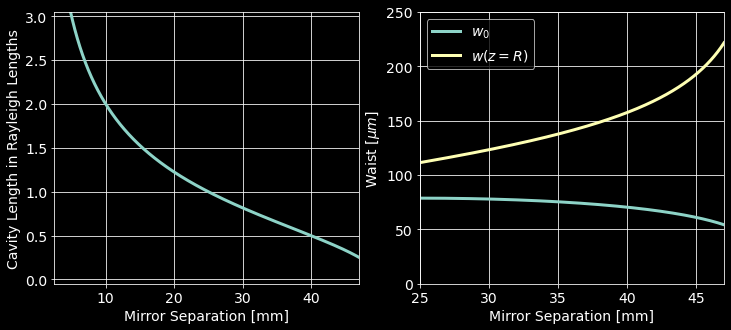

In [2]:
# all lengths in mm

R = 50 # Mirror radius
lmd = 780e-6 # Optical wavelength

d = linspace(lmd,R*.94,100000) # Mirror separation

# define Rayliegh ranges for mode-matching and corresponding waists
zR = sqrt(d*R-d**2)
w0 = sqrt(lmd*zR/pi)

fig,(ax1,ax2) = subplots(1,2,figsize=(12,5))
ax1.plot(d,zR/d,lw = 3)
ax2.plot(d,w0*1e3,lw = 3,label = '$w_0$')
ax2.plot(d,w0*sqrt(1+(d/zR)**2)*1e3,lw = 3,label='$w(z=R)$')
ax2.legend()
ax1.set_xlabel('Mirror Separation [mm]')
ax2.set_xlabel('Mirror Separation [mm]')
ax1.set_ylabel('Cavity Length in Rayleigh Lengths')
ax2.set_ylabel('Waist [$\mu m$]')
ax1.set_xlim(array([R/20,R*.94]))
ax2.set_xlim(array([R/2,R*.94]))
ax1.grid(True)
ax2.grid(True)
ax1.set_ylim(array([-.05,3.05]))
ax2.set_ylim(array([0,.25])*1e3)

## Define the matrices and Gaussian beam transformation

Given the cavity length, and the correspoding required waist, how do we get such a mode into the cavity?

It is perhaps simpler to exploit reversability and say that we stary with the correct mode. What will this mode look like outside the cavity? This is the mode we want. A complication is that the cavity substrate has finite thickness (about 7.5mm) so that upon reflection it acts as concave morror but to the transmitted portion, it looks like a thick, diverging plano-concave lens. The cavity mode will then diverge as a result of this lens upon exit. If we place a converging lens at a correct distance from the cavity hoever, this output mode will be collimated with some waist. 

Then, applying reversibility, if we send a collimated beam with this waist to the converging lens, into the cavity it will be in the correct mode. 

We can calculate the transformation of the Gaussian beam owing to this system using the matrix approach. First we define the matrices and transformation rule:

In [3]:
def ray(h,alp):
    return array([[h],[alp]])
def Tmat(d):
    return array([[1, d],[0,1]])
def Rmat(R,n1=1,n2=1.5):
    return array([[1, 0],[(n1-n2)/(n2*R),n1/n2]])
def TL(R1,R2,d,n,n0=1):
    return Rmat(-R2,n1=n,n2=n0)@Tmat(d)@Rmat(R1,n1=n0,n2=n)
def L(f):
    return array([[1, 0],[-1/f,1]])

def transform_gauss(q, Tmat):
    return (Tmat[0,0]*q + Tmat[0,1])/(Tmat[1,0]*q + Tmat[1,1])

Next, we determine the cavity mode immediately upon exit from the cavity

In [4]:
R = 50
d = R/2 # Cavity Length 
zR = sqrt(d*R-d**2) # Corresponding zR
w0 = sqrt(lmd*zR/pi) # Corresponding w0
Tm = 7.5 # Thickness of Mirror

q = 1j*zR # Initial beam at cavity center

# Matrix of trip from center of cavity to outside mirror substrate
Mtot = TL(-R,1e9,Tm,1.5)@Tmat(d)

# resultant Gaussian beam
q2 = transform_gauss(q,Mtot)
w02 = sqrt(-lmd/(pi*imag(1/q2))) # Waist at exit

print(f'Beam exits with origin {round(real(q2),1)}mm inside the cavity.')
print(f'Beam waist at exit:  {round(w02*1e3,1)}um.')
print(f'New Rayleigh Range:  {round(imag(q2),1)}mm.')

Beam exits with origin 28.1mm inside the cavity.
Beam waist at exit:  128.6um.
New Rayleigh Range:  15.4mm.


We see that the beam has a given width upon exit and <em>appears</em> to exit the cavity closer than $T_m+d$ due to refraction. We'll place a lense with a given focal lenght some distance $x$ away from the cavity. For some distance, the beam will be collimated and this is the position we will use in the experiment.

Place f = 100mm lens a distance 69.5mm from the cavity.


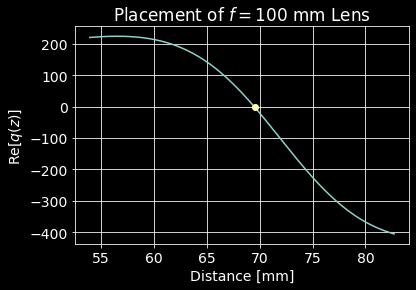

In [5]:
f = 100
x_g = f - real(q2)
zL = linspace(x_g*0.75,x_g*1.15,1000)
zz = array([])
for k in zL:
    zz = append(zz,real(transform_gauss(q2,L(f)@Tmat(k))))

idx = argwhere(zz<0)[0]

fig,ax = subplots()
ax.plot(zL,zz)
ax.plot(zL[idx],zz[idx],'o')
ax.set_xlabel('Distance [mm]')
ax.set_ylabel('Re[$q(z)$]')
ax.set_title(f'Placement of $f=${f} mm Lens')
grid(True)

print(f'Place f = {f}mm lens a distance {round(zL[idx][0],1)}mm from the cavity.')